1. [Kütüphanelerin Tanımlanması](#1)
1. [Veriyi Okuma](#2)
1. [Veriyi Anlama (Data Understanding)](#3)
1. [Öznitelik Çıkarımı (Feature Engineering)](#4)
  1. [İşlem Türü Değişimi](#4.1)
  1. [Ay ve Yıl Verisi Eklenmesi](#4.2)
  1. [Dolar Verisi Eklenmesi](#4.3)
  1. [Sektör Sınıflandırılması](#4.4)
  1. [Yıl Çeyrek Bilgilerinin Eklenmesi](#4.5)
  1. [Müşteri Sınıflandırılması](#4.6)
  1. [Müşterilerin Ortalama İşlem Adedi ve İşlem Tutarı](#4.7)
  1. [Gereksiz Sütunların Silinmesi](#4.8)
1. [Encoding](#5)
1. [Train-Test Split](#6)
1. [Model](#7)
  1. [Baz Model](#7.1)
  1. [1. Model](#7.2)
  1. [2. Model](#7.3)
  1. [3. Model](#7.4)
  1. [4. Model](#7.5)
  1. [5. Model](#7.6)
  1. [6. Model](#7.7)
  1. [7. Model](#7.8)
  1. [8. Model](#7.9)
  1. [9. Model](#7.10)
  1. [10. Model](#7.11)

<a id="1"></a> <br>
# 1- Kütüphanelerin Tanımlanması

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

YIL_AY -harcamaların yapıldığı tarih (YIL ve AY formatında)

ISLEM_TURU -harcamaların türü (peşin ya da taksitli)

SEKTOR -harcamaların yapıldığı sektör

CUSTOMER -her müşterinin unique müşteri numarası

ISLEM_ADEDI -ilgili tarih, tür ve sektörde müşterinin yaptığı işlem adedi

ISLEM_TUTARI -müşterinin ilgili tarih, tür ve sektörde yaptığı işlemlerin toplam tutarı

ID sektörün ID'si (submission dosyasındaki sektor_id)

<a id="2"></a> <br>
# 2- Veriyi Okuma

In [102]:
submission_df = pd.read_csv('Data/sampleSubmission.csv')
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test_set.csv')

In [103]:
train = train_df.copy()
test = test_df.copy()
submission = submission_df.copy()

<a id="3"></a> <br>
# 3- Veriyi Anlama

In [44]:
# Verilerdeki kolonlarin veri tiplerine bakiyoruz

print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
print(train.info())
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
print(test.info())

---------------------------------
TRAIN
---------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3526234 entries, 0 to 3526233
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   ISLEM_TUTARI  float64
 1   ISLEM_ADEDI   float64
 2   ISLEM_TURU    object 
 3   YIL_AY        int64  
 4   SEKTOR        object 
 5   Record_Count  int64  
 6   CUSTOMER      int64  
 7   Id            int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 215.2+ MB
None


---------------------------------
TEST
---------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219666 entries, 0 to 219665
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ISLEM_TUTARI  0 non-null       float64
 1   ISLEM_ADEDI   219666 non-null  float64
 2   ISLEM_TURU    219666 non-null  object 
 3   YIL_AY        219666 non-null  int64  
 4   SEKTOR        21966

In [5]:
# Verilerdeki bos satirlara bakiyoruz

print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
print(train.isna().sum())
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
print(test.isna().sum())

---------------------------------
TRAIN
---------------------------------

ISLEM_TUTARI    0
ISLEM_ADEDI     0
ISLEM_TURU      0
YIL_AY          0
SEKTOR          0
Record_Count    0
CUSTOMER        0
Id              0
dtype: int64


---------------------------------
TEST
---------------------------------

ISLEM_TUTARI    219666
ISLEM_ADEDI          0
ISLEM_TURU           0
YIL_AY               0
SEKTOR               0
Record_Count         0
CUSTOMER             0
Id                   0
dtype: int64


In [6]:
# Verilerdeki kolonlarin unique eleman sayilarina bakiyoruz

print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
for i in train.columns:
    print(i,' kolonundaki unique eleman sayisi',train[i].nunique())
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
for i in test.columns:
    print(i,' kolonundaki unique eleman sayisi',train[i].nunique())

---------------------------------
TRAIN
---------------------------------

ISLEM_TUTARI  kolonundaki unique eleman sayisi 205668
ISLEM_ADEDI  kolonundaki unique eleman sayisi 288
ISLEM_TURU  kolonundaki unique eleman sayisi 2
YIL_AY  kolonundaki unique eleman sayisi 15
SEKTOR  kolonundaki unique eleman sayisi 39
Record_Count  kolonundaki unique eleman sayisi 8
CUSTOMER  kolonundaki unique eleman sayisi 49941
Id  kolonundaki unique eleman sayisi 39


---------------------------------
TEST
---------------------------------

ISLEM_TUTARI  kolonundaki unique eleman sayisi 205668
ISLEM_ADEDI  kolonundaki unique eleman sayisi 288
ISLEM_TURU  kolonundaki unique eleman sayisi 2
YIL_AY  kolonundaki unique eleman sayisi 15
SEKTOR  kolonundaki unique eleman sayisi 39
Record_Count  kolonundaki unique eleman sayisi 8
CUSTOMER  kolonundaki unique eleman sayisi 49941
Id  kolonundaki unique eleman sayisi 39


<a id="4"></a> <br>
# 4- Öznitelik Çıkarımı (Feature Engineering)

<a id="4.1"></a> <br>
## İşlem Türü Değişimi

In [104]:
# ISLEM_TURU kolonundaki degerleri PESIN ise 1 TAKSITLI ise 0 olarak degistiriyoruz

train['ISLEM_TURU'] = train['ISLEM_TURU'].apply(lambda x: 1 if x =='PESIN' else 0)

test['ISLEM_TURU'] = test['ISLEM_TURU'].apply(lambda x: 1 if x =='PESIN' else 0)

<a id="4.2"></a> <br>
## Ay ve Yıl Verisi Eklenmesi

In [105]:
# Verilerdeki Yil ve Ay degerlerini kolon olarak ekliyoruz

train['YIL'] = train['YIL_AY'].apply(lambda x: str(x)[:4])
train['YIL'] = train['YIL'].astype(int)

train['AY'] = train['YIL_AY'].apply(lambda x: str(x)[4:])
train['AY'] = train['AY'].astype(int)



test['YIL'] = test['YIL_AY'].apply(lambda x: str(x)[:4])
test['YIL'] = test['YIL'].astype(int)

test['AY'] = test['YIL_AY'].apply(lambda x: str(x)[4:])
test['AY'] = test['AY'].astype(int)

<a id="4.3"></a> <br>
## Dolar Verisi Eklenmesi

In [106]:
# Dolar kur bilgisini kolon olarak verilere ekliyoruz

train['DOLAR'] = train['YIL_AY'].apply(lambda x: 3.91 if x == 201711 else(3.79 if x == 201712 else(3.75 if x == 201801 else(3.79 if x == 201802 else(3.95 if x == 201803 else(4.06 if x == 201804 else(4.52 if x == 201805 else(4.58 if x == 201806 else(4.91 if x == 201807 else(6.50 if x == 201808 else(6.05 if x == 201809 else(5.58 if x == 201810 else(5.21 if x == 201811 else (5.28 if x == 201812 else(5.16 if x == 201901 else(np.nan))))))))))))))))


test['DOLAR'] = 5.33

<a id="4.4"></a> <br>
## Sektör Sınıflandırılması

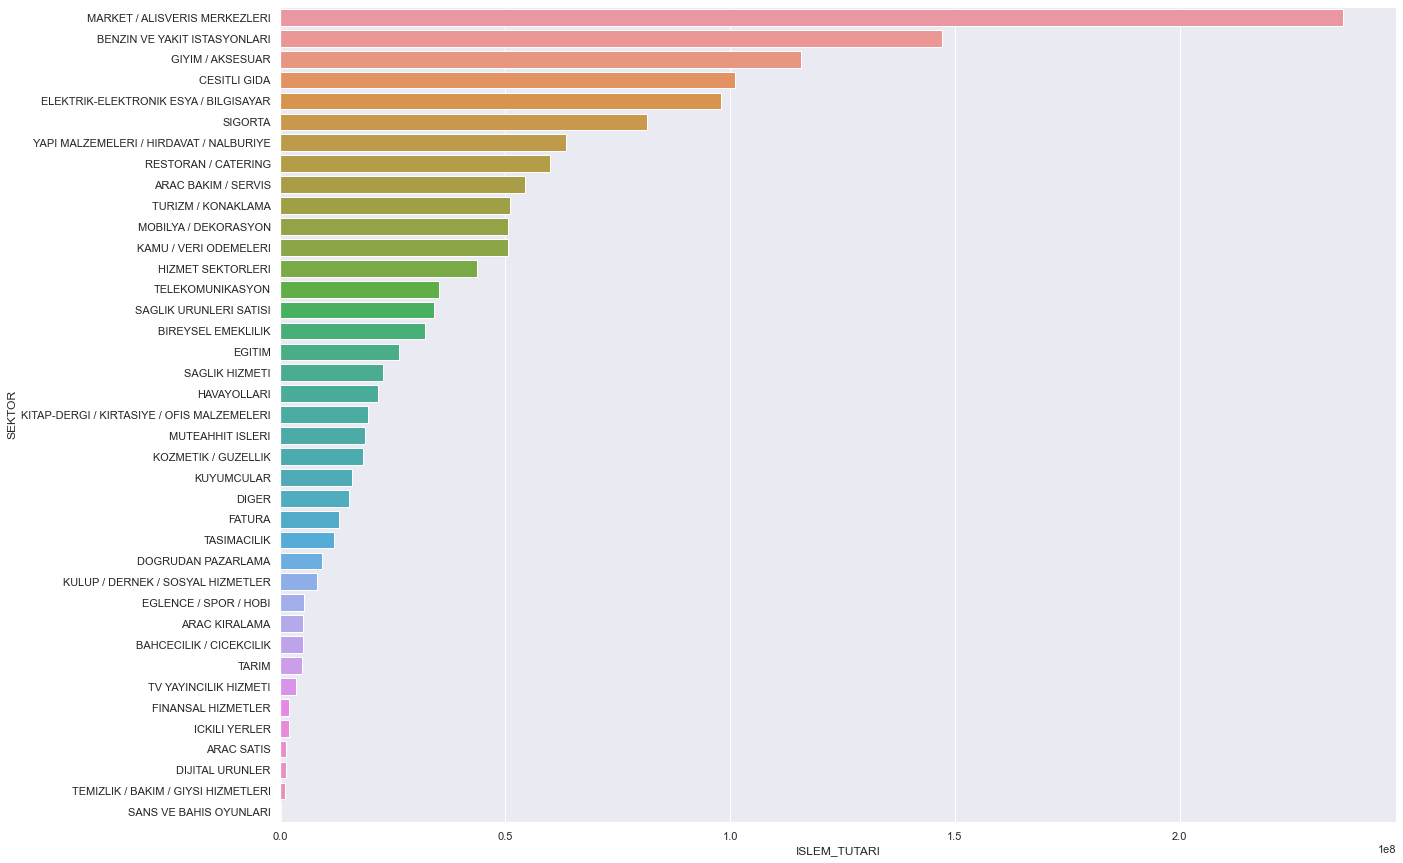

In [107]:
# Sektorlere gore toplam harcamalara bakiyoruz
sektor_harcamalari = train.groupby(['SEKTOR'])[['ISLEM_TUTARI']].sum().sort_values('ISLEM_TUTARI',ascending=False).reset_index()

sns.barplot(y=sektor_harcamalari['SEKTOR'],x=sektor_harcamalari['ISLEM_TUTARI'])
sns.set(rc={'figure.figsize':(20,15)})

In [108]:
# Sektorleri harcamalara gore siniflara ayiriyoruz

'''
1. sinif = 'MARKET / ALISVERIS MERKEZLERI'

2. sinif = 'BENZIN VE YAKIT ISTASYONLARI', 'GIYIM / AKSESUAR', 'CESITLI GIDA', 'ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR', 'SIGORTA' 

3. sinif = 'YAPI MALZEMELERI / HIRDAVAT / NALBURIYE', 'RESTORAN / CATERING', 'ARAC BAKIM / SERVIS', 'TURIZM / KONAKLAMA', 'MOBILYA / DEKORASYON', 'KAMU / VERI ODEMELERI', 'HIZMET SEKTORLERI'

4. sinif = 'TELEKOMUNIKASYON', 'SAGLIK URUNLERI SATISI', 'BIREYSEL EMEKLILIK', 'EGITIM', 'SAGLIK HIZMETI', 'HAVAYOLLARI', 'KITAP-DERGI / KIRTASIYE / OFIS MALZEMELERI', 'MUTEAHHIT ISLERI', 'KOZMETIK / GUZELLIK', 'KUYUMCULAR', 'DIGER', 'FATURA', 'TASIMACILIK', 'DOGRUDAN PAZARLAMA', 'KULUP / DERNEK / SOSYAL HIZMETLER'

5. sinif = 'EGLENCE / SPOR / HOBI', 'ARAC KIRALAMA', 'BAHCECILIK / CICEKCILIK', 'TARIM', 'TV YAYINCILIK HIZMETI'

6. sinif = 'FINANSAL HIZMETLER', 'ICKILI YERLER', 'ARAC SATIS', 'DIJITAL URUNLER', 'TEMIZLIK / BAKIM / GIYSI HIZMETLERI', 'SANS VE BAHIS OYUNLARI'

'''

"\n1. sinif = 'MARKET / ALISVERIS MERKEZLERI'\n\n2. sinif = 'BENZIN VE YAKIT ISTASYONLARI', 'GIYIM / AKSESUAR', 'CESITLI GIDA', 'ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR', 'SIGORTA' \n\n3. sinif = 'YAPI MALZEMELERI / HIRDAVAT / NALBURIYE', 'RESTORAN / CATERING', 'ARAC BAKIM / SERVIS', 'TURIZM / KONAKLAMA', 'MOBILYA / DEKORASYON', 'KAMU / VERI ODEMELERI', 'HIZMET SEKTORLERI'\n\n4. sinif = 'TELEKOMUNIKASYON', 'SAGLIK URUNLERI SATISI', 'BIREYSEL EMEKLILIK', 'EGITIM', 'SAGLIK HIZMETI', 'HAVAYOLLARI', 'KITAP-DERGI / KIRTASIYE / OFIS MALZEMELERI', 'MUTEAHHIT ISLERI', 'KOZMETIK / GUZELLIK', 'KUYUMCULAR', 'DIGER', 'FATURA', 'TASIMACILIK', 'DOGRUDAN PAZARLAMA', 'KULUP / DERNEK / SOSYAL HIZMETLER'\n\n5. sinif = 'EGLENCE / SPOR / HOBI', 'ARAC KIRALAMA', 'BAHCECILIK / CICEKCILIK', 'TARIM', 'TV YAYINCILIK HIZMETI'\n\n6. sinif = 'FINANSAL HIZMETLER', 'ICKILI YERLER', 'ARAC SATIS', 'DIJITAL URUNLER', 'TEMIZLIK / BAKIM / GIYSI HIZMETLERI', 'SANS VE BAHIS OYUNLARI'\n\n"

In [109]:
def sektor_sinifi(df):
    
    df.loc[df['SEKTOR'].str.contains('MARKET / ALISVERIS MERKEZLERI', na=False), 'SEKTOR_SINIF'] = '1'
    
    df.loc[df['SEKTOR'].str.contains('BENZIN VE YAKIT ISTASYONLARI', na=False), 'SEKTOR_SINIF'] = '2'
    df.loc[df['SEKTOR'].str.contains('GIYIM / AKSESUAR', na=False), 'SEKTOR_SINIF'] = '2'
    df.loc[df['SEKTOR'].str.contains('CESITLI GIDA', na=False), 'SEKTOR_SINIF'] = '2'
    df.loc[df['SEKTOR'].str.contains('ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR', na=False), 'SEKTOR_SINIF'] = '2'
    df.loc[df['SEKTOR'].str.contains('SIGORTA', na=False), 'SEKTOR_SINIF'] = '2'

    df.loc[df['SEKTOR'].str.contains('YAPI MALZEMELERI / HIRDAVAT / NALBURIYE', na=False), 'SEKTOR_SINIF'] = '3'
    df.loc[df['SEKTOR'].str.contains('RESTORAN / CATERING', na=False), 'SEKTOR_SINIF'] = '3'
    df.loc[df['SEKTOR'].str.contains('ARAC BAKIM / SERVIS', na=False), 'SEKTOR_SINIF'] = '3'
    df.loc[df['SEKTOR'].str.contains('TURIZM / KONAKLAMA', na=False), 'SEKTOR_SINIF'] = '3'
    df.loc[df['SEKTOR'].str.contains('MOBILYA / DEKORASYON', na=False), 'SEKTOR_SINIF'] = '3'
    df.loc[df['SEKTOR'].str.contains('KAMU / VERI ODEMELERI', na=False), 'SEKTOR_SINIF'] = '3'
    df.loc[df['SEKTOR'].str.contains('HIZMET SEKTORLERI', na=False), 'SEKTOR_SINIF'] = '3'
    
    df.loc[df['SEKTOR'].str.contains('TELEKOMUNIKASYON', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('SAGLIK URUNLERI SATISI', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('BIREYSEL EMEKLILIK', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('EGITIM', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('SAGLIK HIZMETI', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('HAVAYOLLARI', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('KITAP-DERGI / KIRTASIYE / OFIS MALZEMELERI', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('MUTEAHHIT ISLERI', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('KOZMETIK / GUZELLIK', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('KUYUMCULAR', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('DIGER', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('FATURA', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('TASIMACILIK', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('DOGRUDAN PAZARLAMA', na=False), 'SEKTOR_SINIF'] = '4'
    df.loc[df['SEKTOR'].str.contains('KULUP / DERNEK / SOSYAL HIZMETLER', na=False), 'SEKTOR_SINIF'] = '4'

    df.loc[df['SEKTOR'].str.contains('EGLENCE / SPOR / HOBI', na=False), 'SEKTOR_SINIF'] = '5'
    df.loc[df['SEKTOR'].str.contains('ARAC KIRALAMA', na=False), 'SEKTOR_SINIF'] = '5'
    df.loc[df['SEKTOR'].str.contains('BAHCECILIK / CICEKCILIK', na=False), 'SEKTOR_SINIF'] = '5'
    df.loc[df['SEKTOR'].str.contains('TARIM', na=False), 'SEKTOR_SINIF'] = '5'
    df.loc[df['SEKTOR'].str.contains('TV YAYINCILIK HIZMETI', na=False), 'SEKTOR_SINIF'] = '5'
    
    df.loc[df['SEKTOR'].str.contains('FINANSAL HIZMETLER', na=False), 'SEKTOR_SINIF'] = '6'
    df.loc[df['SEKTOR'].str.contains('ICKILI YERLER', na=False), 'SEKTOR_SINIF'] = '6'
    df.loc[df['SEKTOR'].str.contains('ARAC SATIS', na=False), 'SEKTOR_SINIF'] = '6'
    df.loc[df['SEKTOR'].str.contains('DIJITAL URUNLER', na=False), 'SEKTOR_SINIF'] = '6'
    df.loc[df['SEKTOR'].str.contains('TEMIZLIK / BAKIM / GIYSI HIZMETLERI', na=False), 'SEKTOR_SINIF'] = '6'
    df.loc[df['SEKTOR'].str.contains('SANS VE BAHIS OYUNLARI', na=False), 'SEKTOR_SINIF'] = '6'

sektor_sinifi(train)
sektor_sinifi(test)

<a id="4.5"></a> <br>
## Yıl Çeyrek Bilgilerinin Eklenmesi

In [110]:
# Yilin ceyrek donem bilgilerini veriye kolon olarak ekliyoruz



train['CEYREK'] = train['AY'].apply(lambda x: 'Q1' if x == 1 or x == 2 or x == 3 else('Q2' if x == 4 or x == 5 or x == 6 else('Q3' if x == 7 or x == 8 or x == 9 else('Q4' if x == 10 or x == 11 or x == 12 else(np.nan)))))

test['CEYREK'] = test['AY'].apply(lambda x: 'Q1' if x == 1 or x == 2 or x == 3 else('Q2' if x == 4 or x == 5 or x == 6 else('Q3' if x == 7 or x == 8 or x == 9 else('Q4' if x == 10 or x == 11 or x == 12 else(np.nan)))))


<a id="4.6"></a> <br>
## Müşteri Sınıflandırılması

In [111]:
# Musterileri toplam harcama tutarlarina gore siniflara ayiriyoruz

musteri_harcamalari = train.groupby('CUSTOMER').sum()[['ISLEM_TUTARI']].reset_index()

In [112]:
def musteri_sinifi(df):
    
    df.loc[df['ISLEM_TUTARI'] <= 5000, 'MUSTERI_SINIF'] = '1'
    
    df.loc[(df['ISLEM_TUTARI'] > 5000) & (df['ISLEM_TUTARI'] <= 100000), 'MUSTERI_SINIF'] = '2'
    df.loc[(df['ISLEM_TUTARI'] > 100000) & (df['ISLEM_TUTARI'] <= 200000), 'MUSTERI_SINIF'] = '3'
    df.loc[(df['ISLEM_TUTARI'] > 200000) & (df['ISLEM_TUTARI'] <= 300000), 'MUSTERI_SINIF'] = '4'
    df.loc[(df['ISLEM_TUTARI'] > 300000) & (df['ISLEM_TUTARI'] <= 400000), 'MUSTERI_SINIF'] = '5'
    df.loc[(df['ISLEM_TUTARI'] > 400000) & (df['ISLEM_TUTARI'] <= 500000), 'MUSTERI_SINIF'] = '6'
    df.loc[(df['ISLEM_TUTARI'] > 500000) & (df['ISLEM_TUTARI'] <= 600000), 'MUSTERI_SINIF'] = '7'
    df.loc[(df['ISLEM_TUTARI'] > 600000) & (df['ISLEM_TUTARI'] <= 700000), 'MUSTERI_SINIF'] = '8'
    df.loc[(df['ISLEM_TUTARI'] > 700000) & (df['ISLEM_TUTARI'] <= 800000), 'MUSTERI_SINIF'] = '9'
    df.loc[(df['ISLEM_TUTARI'] > 800000) & (df['ISLEM_TUTARI'] <= 900000), 'MUSTERI_SINIF'] = '10'
    df.loc[(df['ISLEM_TUTARI'] > 900000) & (df['ISLEM_TUTARI'] <= 1000000), 'MUSTERI_SINIF'] = '11'
    
    df.loc[df['ISLEM_TUTARI'] > 1000000, 'MUSTERI_SINIF'] = '12'

musteri_sinifi(musteri_harcamalari)

In [113]:
musteri_harcamalari

,CUSTOMER,ISLEM_TUTARI,MUSTERI_SINIF
0,1,181063.07,3
1,2,535874.39,7
2,3,183980.03,3
3,4,123909.24,3
4,5,107883.92,3
...,...,...,...
49936,49996,1589.87,1
49937,49997,3100.12,1
49938,49998,50804.00,2
49939,49999,1140.00,1


In [114]:
train = pd.merge(train, musteri_harcamalari[['CUSTOMER','MUSTERI_SINIF']], on='CUSTOMER')
test = pd.merge(test, musteri_harcamalari[['CUSTOMER','MUSTERI_SINIF']], on='CUSTOMER')

<a id="4.7"></a> <br>
## Müşterilerin Ortalama İşlem Adedi ve İşlem Tutarı

In [115]:
# Musterilerin ortalama islem adedi ve islem tutarlarini buluyoruz

musteri_ortalama = train.groupby('CUSTOMER').mean()[['ISLEM_ADEDI','ISLEM_TUTARI']].rename(columns={'ISLEM_ADEDI':'ORTALAMA_ISLEM_ADET','ISLEM_TUTARI':'ORTALAMA_ISLEM_TUTAR'})

In [116]:
# Buldugumuz verileri kolon olarak ekliyoruz

train = pd.merge(train,musteri_ortalama, on='CUSTOMER')
test = pd.merge(test,musteri_ortalama, on='CUSTOMER')

<a id="4.8"></a> <br>
## Gereksiz Sütunların Silinmesi

In [117]:
# Verilerdeki Record_Count kolonunu siliyoruz

train.drop(['Record_Count','YIL_AY','SEKTOR'],axis=1,inplace=True)

test.drop(['Record_Count','YIL_AY','SEKTOR'],axis=1,inplace=True)

In [118]:
train

,ISLEM_TUTARI,ISLEM_ADEDI,ISLEM_TURU,CUSTOMER,Id,YIL,AY,DOLAR,SEKTOR_SINIF,CEYREK,MUSTERI_SINIF,ORTALAMA_ISLEM_ADET,ORTALAMA_ISLEM_TUTAR
0,279.94,2.0,1,219,15,2017,11,3.91,2,Q4,2,3.131455,376.575399
1,180.50,13.0,1,219,6,2017,11,3.91,2,Q4,2,3.131455,376.575399
2,141.50,2.0,1,219,29,2017,11,3.91,4,Q4,2,3.131455,376.575399
3,138.18,4.0,1,219,12,2017,11,3.91,2,Q4,2,3.131455,376.575399
4,301.49,8.0,1,219,24,2017,11,3.91,1,Q4,2,3.131455,376.575399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3526229,129.98,1.0,0,49601,15,2018,12,5.28,2,Q4,1,1.500000,229.470000
3526230,258.50,1.0,1,47829,19,2018,12,5.28,3,Q4,1,1.000000,216.166667
3526231,290.00,1.0,1,47829,10,2019,1,5.16,4,Q1,1,1.000000,216.166667
3526232,100.00,1.0,1,47829,4,2019,1,5.16,2,Q1,1,1.000000,216.166667


In [119]:
test

,ISLEM_TUTARI,ISLEM_ADEDI,ISLEM_TURU,CUSTOMER,Id,YIL,AY,DOLAR,SEKTOR_SINIF,CEYREK,MUSTERI_SINIF,ORTALAMA_ISLEM_ADET,ORTALAMA_ISLEM_TUTAR
0,NaN,2.0,1,1,12,2019,2,5.33,2,Q1,3,4.308869,553.709694
1,NaN,21.0,1,1,27,2019,2,5.33,3,Q1,3,4.308869,553.709694
2,NaN,4.0,1,1,21,2019,2,5.33,4,Q1,3,4.308869,553.709694
3,NaN,7.0,1,1,33,2019,2,5.33,4,Q1,3,4.308869,553.709694
4,NaN,2.0,1,1,37,2019,2,5.33,5,Q1,3,4.308869,553.709694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219658,NaN,1.0,1,49990,7,2019,2,5.33,4,Q1,3,1.444444,15598.616667
219659,NaN,3.0,1,49994,8,2019,2,5.33,6,Q1,1,3.111111,147.725556
219660,NaN,1.0,1,49997,5,2019,2,5.33,4,Q1,1,3.333333,344.457778
219661,NaN,1.0,1,49998,6,2019,2,5.33,2,Q1,2,1.000000,5644.888889


<a id="5"></a> <br>
# 5- Encoding

In [120]:
encod_cols = ['YIL','AY','CEYREK','SEKTOR_SINIF','MUSTERI_SINIF','Id']

## YIL

In [121]:
print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(train.shape))
df = pd.get_dummies(train, columns=[encod_cols[0]], drop_first=True)
print('Dummy sonrası shape: {}'.format(df.shape))
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(test.shape))
test_df = test.copy()
test_df['YIL_2018'] = 0
test_df['YIL_2019'] = 1
test_df.drop(['YIL'],axis=1,inplace=True)
print('Dummy sonrası shape: {}'.format(test_df.shape))

---------------------------------
TRAIN
---------------------------------

Dummy öncesi shape: (3526234, 13)
Dummy sonrası shape: (3526234, 14)


---------------------------------
TEST
---------------------------------

Dummy öncesi shape: (219663, 13)
Dummy sonrası shape: (219663, 14)


## AY

In [122]:
print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(df.shape))
df = pd.get_dummies(df, columns=[encod_cols[1]], drop_first=True)
print('Dummy sonrası shape: {}'.format(df.shape))
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(test_df.shape))
test_df['AY_2'],test_df['AY_3'],test_df['AY_4'],test_df['AY_5'],test_df['AY_6'],test_df['AY_7'],test_df['AY_8'],test_df['AY_9'],test_df['AY_10'],test_df['AY_11'],test_df['AY_12'] = [1,0,0,0,0,0,0,0,0,0,0]
test_df.drop(['AY'],axis=1,inplace=True)
print('Dummy sonrası shape: {}'.format(test_df.shape))

---------------------------------
TRAIN
---------------------------------

Dummy öncesi shape: (3526234, 14)
Dummy sonrası shape: (3526234, 24)


---------------------------------
TEST
---------------------------------

Dummy öncesi shape: (219663, 14)
Dummy sonrası shape: (219663, 24)


## ÇEYREK

In [123]:
print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(df.shape))
df = pd.get_dummies(df, columns=[encod_cols[2]], drop_first=True)
print('Dummy sonrası shape: {}'.format(df.shape))
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(test_df.shape))
test_df['CEYREK_Q2'],test_df['CEYREK_Q3'],test_df['CEYREK_Q4'] = [0,0,0]
test_df.drop(['CEYREK'],axis=1,inplace=True)
print('Dummy sonrası shape: {}'.format(test_df.shape))

---------------------------------
TRAIN
---------------------------------

Dummy öncesi shape: (3526234, 24)
Dummy sonrası shape: (3526234, 26)


---------------------------------
TEST
---------------------------------

Dummy öncesi shape: (219663, 24)
Dummy sonrası shape: (219663, 26)


## SEKTOR_SINIF

In [124]:
print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(df.shape))
df = pd.get_dummies(df, columns=[encod_cols[3]], drop_first=True)
print('Dummy sonrası shape: {}'.format(df.shape))
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(test_df.shape))
test_df = pd.get_dummies(test_df, columns=[encod_cols[3]], drop_first=True)
print('Dummy sonrası shape: {}'.format(test_df.shape))

---------------------------------
TRAIN
---------------------------------

Dummy öncesi shape: (3526234, 26)
Dummy sonrası shape: (3526234, 30)


---------------------------------
TEST
---------------------------------

Dummy öncesi shape: (219663, 26)
Dummy sonrası shape: (219663, 30)


## MUSTERI_SINIF

In [125]:
print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(df.shape))
df = pd.get_dummies(df, columns=[encod_cols[4]], drop_first=True)
print('Dummy sonrası shape: {}'.format(df.shape))
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(test_df.shape))
test_df = pd.get_dummies(test_df, columns=[encod_cols[4]], drop_first=True)
print('Dummy sonrası shape: {}'.format(test_df.shape))

---------------------------------
TRAIN
---------------------------------

Dummy öncesi shape: (3526234, 30)
Dummy sonrası shape: (3526234, 40)


---------------------------------
TEST
---------------------------------

Dummy öncesi shape: (219663, 30)
Dummy sonrası shape: (219663, 40)


## Id

In [ ]:
print('---------------------------------')
print("TRAIN")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(df.shape))
df = pd.get_dummies(df, columns=[encod_cols[5]],prefix='SEKTOR_ID', drop_first=True)
print('Dummy sonrası shape: {}'.format(df.shape))
print('\n')
print('---------------------------------')
print("TEST")
print('---------------------------------\n')
print('Dummy öncesi shape: {}'.format(test_df.shape))
test_df = pd.get_dummies(test_df, columns=[encod_cols[5]],prefix='SEKTOR_ID' , drop_first=True)
print('Dummy sonrası shape: {}'.format(test_df.shape))

In [126]:
df.to_csv('df.csv',index=False)
test_df.to_csv('test_df.csv',index=False)

<a id="6"></a> <br>
# 6- Train-Test Split

In [ ]:
# 2019 Ocak ayini test seti olarak ayarliyoruz

x_test = df[(df['YIL_2019']==1)].drop(['ISLEM_TUTARI'],axis=1)
y_test = df[(df['YIL_2019']==1)][['ISLEM_TUTARI']]

x_train = df[~(df['YIL_2019']==1)].drop(['ISLEM_TUTARI'],axis=1)
y_train = df[~(df['YIL_2019']==1)][['ISLEM_TUTARI']]

<a id="7"></a> <br>
# 7- Model

<a id="7.1"></a> <br>
## Baz Model

In [25]:
# y_train verisinin ortalamasi ile baz bir model olusturuyoruz. Bu modelde cikan hata en kotu modelin verdigi hatadir. Amacimiz bu hatayi dusurmek

In [26]:
y_train['ISLEM_TUTARI'].mean()

421.5563907574824

In [27]:
y_test['ortalama'] = 421.5563907574824

In [28]:
mean_squared_log_error(y_test['ISLEM_TUTARI'],y_test['ortalama'])

3.0802896890678464

In [29]:
y_test

,ISLEM_TUTARI,ortalama
195,300.00,421.556391
196,135.67,421.556391
197,1168.00,421.556391
198,120.00,421.556391
199,65.00,421.556391
...,...,...
3526225,370.00,421.556391
3526226,220.00,421.556391
3526227,199.99,421.556391
3526231,290.00,421.556391


<a id="7.2"></a> <br>
## 1.Model

In [30]:
# Verinin direk ilk hali ile XGBoost modeli kullaniyoruz

xgb_1 = XGBRegressor(n_jobs=-1,verbosity=2)
xgb_1.fit(x_train,y_train,verbose=True,eval_metric='rmsle')

[16:58:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:58:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:58:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:58:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:58:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:58:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:58:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_de

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [31]:
y_test['model_1_pred'] = xgb_1.predict(x_test)

In [83]:
print('RMSLE: ',np.sqrt(mean_squared_log_error(y_test['ISLEM_TUTARI'],abs(y_test['model_1_pred']))))

RMSLE:  1.0821780150902032


In [87]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test['ISLEM_TUTARI'],y_test['model_1_pred'])))

RMSE:  1325.9869040839621


In [88]:
print('R2: ',r2_score(y_test['ISLEM_TUTARI'],y_test['model_1_pred']))

R2:  0.6573266841378194


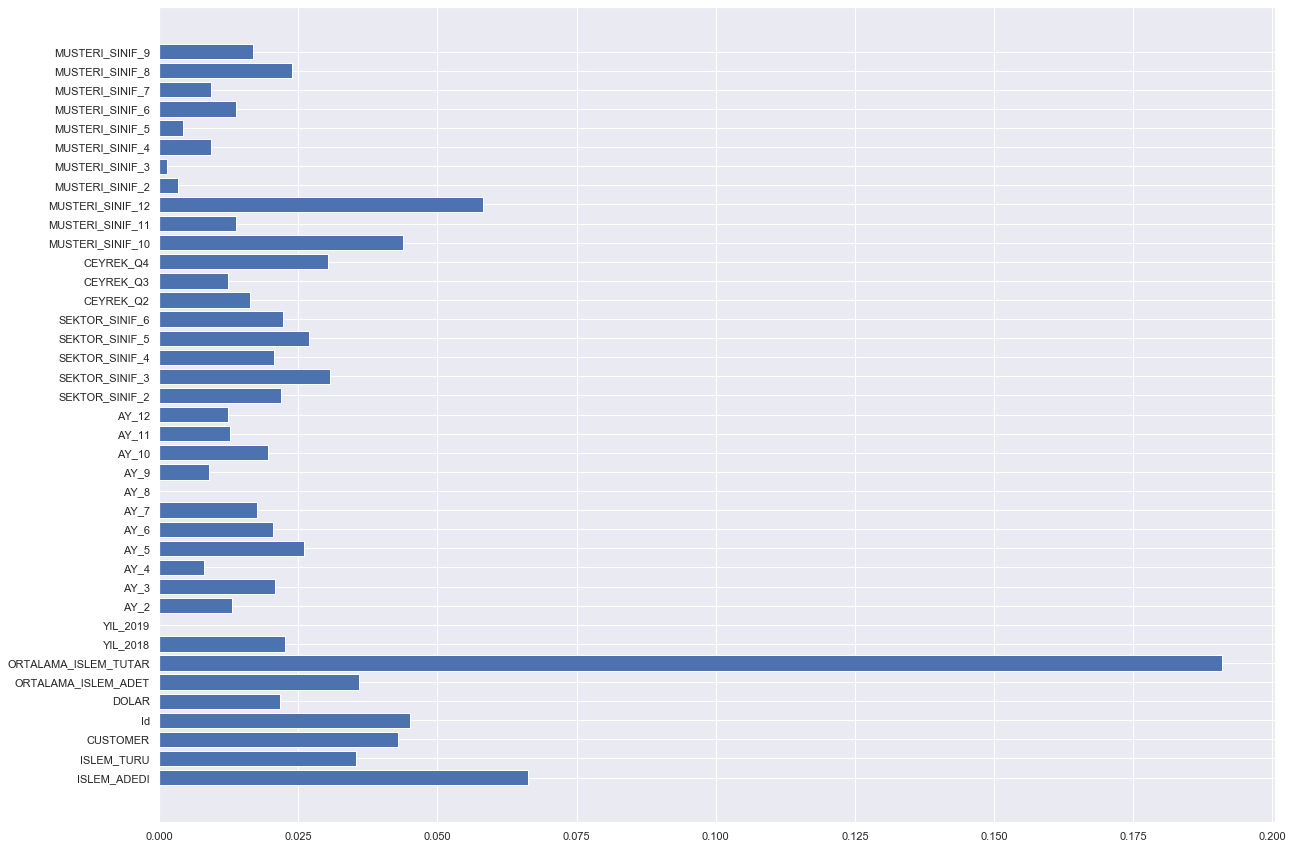

In [33]:
plt.barh(x_train.columns, xgb_1.feature_importances_);

<a id="7.3"></a> <br>
## 2.Model

In [45]:
# Veriyi StandardScaler ile scale edip XGBoost algoritmasini kullaniyoruz

scalerx = StandardScaler().fit(x_train)
scalery = StandardScaler().fit(y_train)

x_train_scaled = scalerx.transform(x_train)
y_train_scaled = scalery.transform(y_train)
x_test_scaled = scalerx.transform(x_test)
y_test_scaled = scalery.transform(y_test)

In [50]:
xgb_2 = XGBRegressor(n_jobs=-1,verbosity=2)
xgb_2.fit(x_train_scaled,y_train_scaled,verbose=True,eval_metric='rmsle')

[17:48:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:48:11] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:48:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:48:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:48:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:48:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:48:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_de

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [58]:
y_test['model_2_pred'] = scalery.inverse_transform(xgb_2.predict(x_test_scaled))

In [91]:
print('RMSLE: ',np.sqrt(mean_squared_log_error(y_test['ISLEM_TUTARI'],abs(y_test['model_2_pred']))))

RMSLE:  1.0786899973738144


In [90]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test['ISLEM_TUTARI'],y_test['model_2_pred'])))

RMSE:  1320.8355248152102


In [89]:
print('R2: ',r2_score(y_test['ISLEM_TUTARI'],y_test['model_2_pred']))

R2:  0.659984042643994


In [62]:
y_test

,ISLEM_TUTARI,ortalama,model_1_pred,model_2_pred
195,300.00,421.556391,131.157349,132.572144
196,135.67,421.556391,323.602356,307.524780
197,1168.00,421.556391,417.203705,364.602448
198,120.00,421.556391,194.412903,206.268494
199,65.00,421.556391,542.236023,515.684753
...,...,...,...,...
3526225,370.00,421.556391,462.125336,426.911987
3526226,220.00,421.556391,225.686447,222.347641
3526227,199.99,421.556391,161.540436,114.007225
3526231,290.00,421.556391,383.361176,448.668213


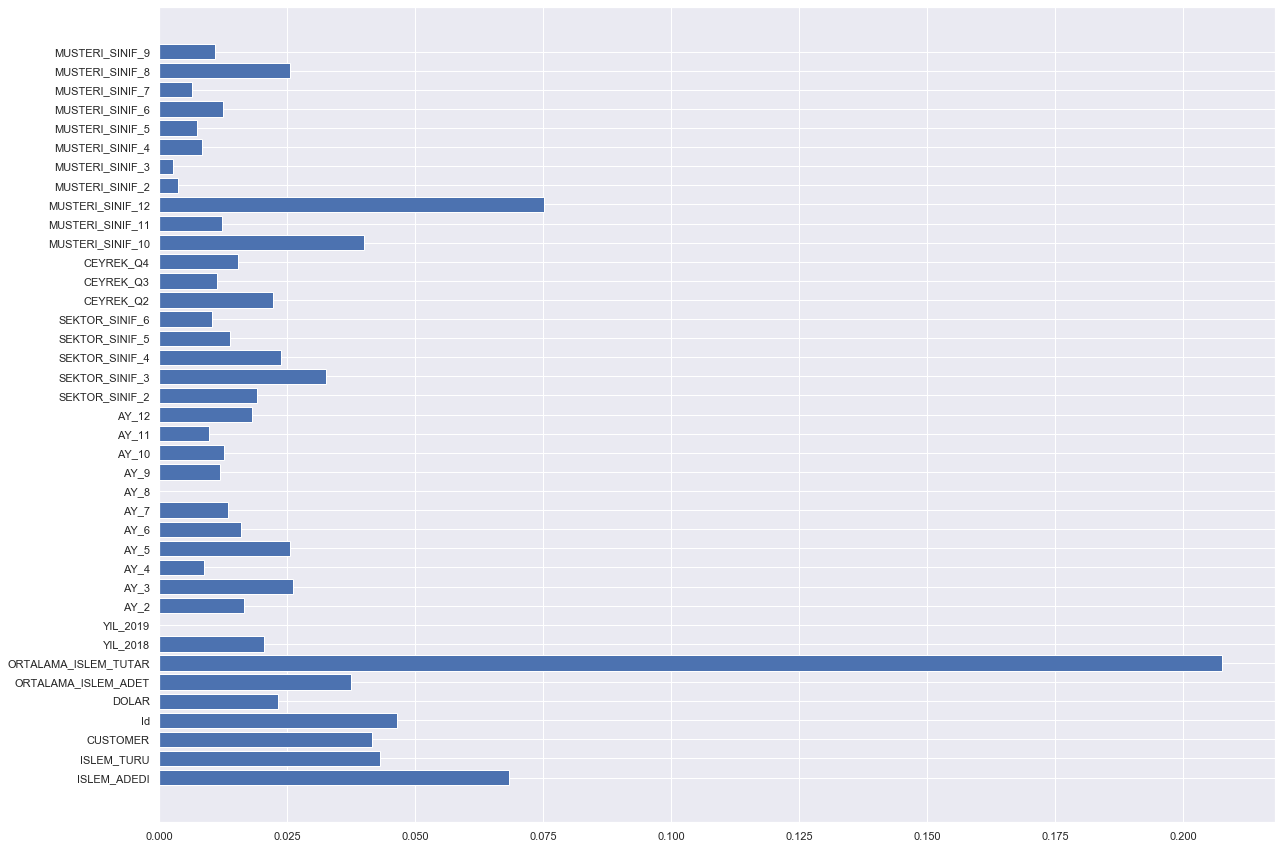

In [63]:
plt.barh(x_train.columns, xgb_2.feature_importances_);

<a id="7.4"></a> <br>
## 3.Model

In [64]:
# Veriyi MinMaxScaler ile scale edip XGBoost algoritmasini kullaniyoruz

mms = MinMaxScaler()

scalerx = MinMaxScaler().fit(x_train)
scalery = MinMaxScaler().fit(y_train)

x_train_scaled = scalerx.transform(x_train)
y_train_scaled = scalery.transform(y_train)
x_test_scaled = scalerx.transform(x_test)
y_test_scaled = scalery.transform(y_test)

In [65]:
xgb_3 = XGBRegressor(n_jobs=-1,verbosity=2)
xgb_3.fit(x_train_scaled,y_train_scaled,verbose=True,eval_metric='rmsle')

[18:03:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:03:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:03:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:03:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:04:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:04:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:04:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [70]:
scalery.inverse_transform(xgb_3.predict(x_test_scaled).reshape(-1, 1))

array([[205.96385],
       [342.5181 ],
       [391.63232],
       ...,
       [207.79669],
       [362.35153],
       [163.82336]], dtype=float32)

In [73]:
y_test['model_3_pred'] = scalery.inverse_transform(xgb_3.predict(x_test_scaled).reshape(-1, 1))

In [92]:
print('RMSLE: ',np.sqrt(mean_squared_log_error(y_test['ISLEM_TUTARI'],abs(y_test['model_3_pred']))))

RMSLE:  1.0705070591005719


In [93]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test['ISLEM_TUTARI'],y_test['model_3_pred'])))

RMSE:  1313.960229155541


In [94]:
print('R2: ',r2_score(y_test['ISLEM_TUTARI'],y_test['model_3_pred']))

R2:  0.6635145746357215


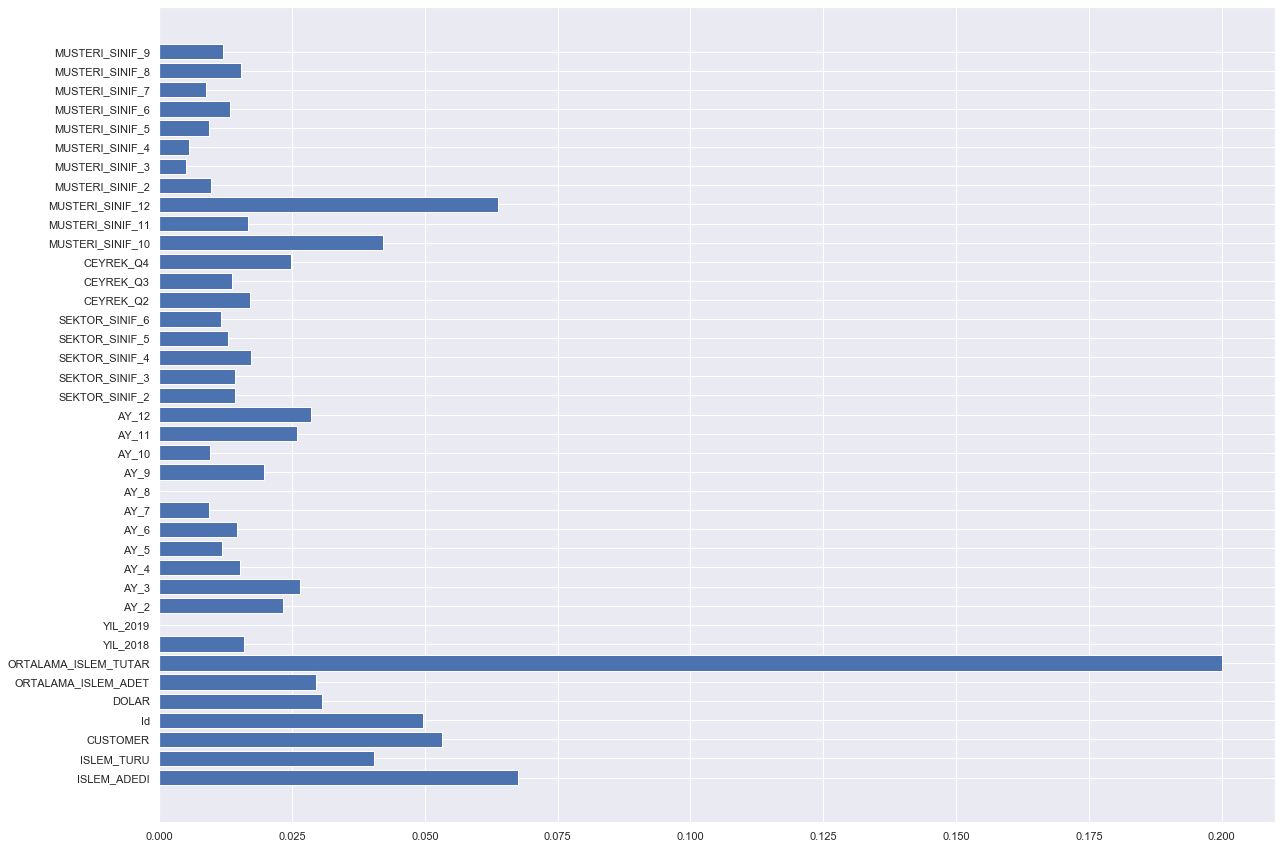

In [76]:
plt.barh(x_train.columns, xgb_3.feature_importances_);

<a id="7.5"></a> <br>
## 4.Model

In [77]:
# Veriyi StandardScaler ile scale edip XGBoost algoritmasini kullaniyoruz

rs = RobustScaler()

scalerx = RobustScaler().fit(x_train)
scalery = RobustScaler().fit(y_train)

x_train_scaled = scalerx.transform(x_train)
y_train_scaled = scalery.transform(y_train)
x_test_scaled = scalerx.transform(x_test)
y_test_scaled = scalery.transform(y_test)

In [78]:
xgb_4 = XGBRegressor(n_jobs=-1,verbosity=2)
xgb_4.fit(x_train_scaled,y_train_scaled,verbose=True,eval_metric='rmsle')

[18:21:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:21:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:22:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:22:07] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:22:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:22:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:22:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_de

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [80]:
y_test['model_4_pred'] = scalery.inverse_transform(xgb_4.predict(x_test_scaled).reshape(-1, 1))

In [95]:
print('RMSLE: ',np.sqrt(mean_squared_log_error(y_test['ISLEM_TUTARI'],abs(y_test['model_4_pred']))))

RMSLE:  1.0797099254348173


In [96]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test['ISLEM_TUTARI'],y_test['model_4_pred'])))

RMSE:  1312.6400558266537


In [97]:
print('R2: ',r2_score(y_test['ISLEM_TUTARI'],y_test['model_4_pred']))

R2:  0.6641903879738724


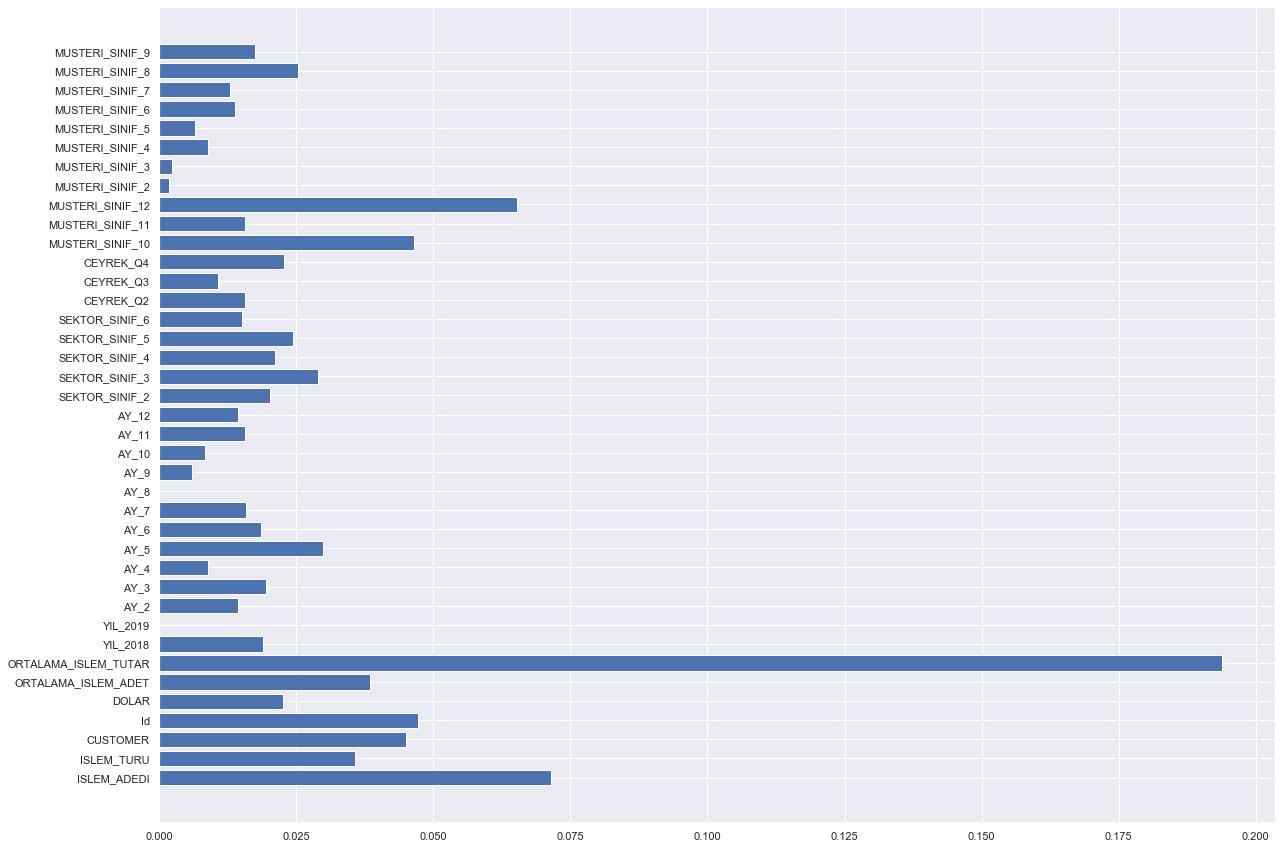

In [82]:
plt.barh(x_train.columns, xgb_4.feature_importances_);

In [105]:
submission['Expected'] = pd.concat([x_test,y_test[['ISLEM_TUTARI']]],axis=1).groupby('Id')[['ISLEM_TUTARI']].sum()

In [107]:
submission.to_csv('XGB_Submission_2.csv',index=False)

<a id="7.6"></a> <br>
## 5.Model

In [262]:
# Bu modelde bütün verilerle eğitim yapıyoruz

In [265]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [266]:
rs = RobustScaler()

scalerx = RobustScaler().fit(x_train)
scalery = RobustScaler().fit(y_train)

x_train_scaled = scalerx.transform(x_train)
y_train_scaled = scalery.transform(y_train)
x_test_scaled = scalerx.transform(x_test)

In [267]:
xgb_5 = XGBRegressor(n_jobs=-1,verbosity=2)
xgb_5.fit(x_train_scaled,y_train_scaled,verbose=True,eval_metric='rmsle')

[11:01:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[11:01:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[11:02:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[11:02:10] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[11:02:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[11:02:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[11:02:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [280]:
test_df['model_5_pred'] = scalery.inverse_transform(xgb_5.predict(x_test_scaled).reshape(-1, 1))

### RMSLE = 0.21065

<a id="7.7"></a> <br>
## 6.Model

In [262]:
# Bu modelde bütün verilerle eğitim yapıyoruz

In [67]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [68]:
rs = RobustScaler()

scalerx = RobustScaler().fit(x_train)
scalery = RobustScaler().fit(y_train)

x_train_scaled = scalerx.transform(x_train)
y_train_scaled = scalery.transform(y_train)
x_test_scaled = scalerx.transform(x_test)

In [69]:
xgb_6 = XGBRegressor(colsample_bytree=0.7, gamma=0.0468, 
                             learning_rate=0.1, max_depth=7, 
                             min_child_weight=1.7817, n_estimators=120,
                             reg_alpha=0.4640, reg_lambda=1.25,
                             subsample=0.5213, silent=0,
                             random_state =7, nthread = -1,n_jobs=-1,verbosity=2 )
xgb_6.fit(x_train_scaled,y_train_scaled,verbose=True,eval_metric='rmsle')

[12:58:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=7
[12:58:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=7
[12:59:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=7
[12:59:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=7
[12:59:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_p

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0468, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=1.25, scale_pos_weight=1, silent=0, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [1]:
test_df['model_6_pred'] = scalery.inverse_transform(xgb_6.predict(x_test_scaled).reshape(-1, 1))

NameError: name 'scalery' is not defined

In [75]:
submission['Expected'] = test_df.groupby('Id')[['model_6_pred']].sum().values
submission.drop(['Predicted'],axis=1,inplace=True)

In [78]:
submission.to_csv('XGB_Submission_3.csv',index=False)

### RMSLE = 0.34316

<a id="7.8"></a> <br>
## 7.Model

In [262]:
# Bu modelde bütün verilerle eğitim yapıyoruz

In [28]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [29]:
rs = RobustScaler()

scalerx = RobustScaler().fit(x_train)
scalery = RobustScaler().fit(y_train)

x_train_scaled = scalerx.transform(x_train)
y_train_scaled = scalery.transform(y_train)
x_test_scaled = scalerx.transform(x_test)

In [43]:
x_test_scaled.shape

(219663, 39)

In [44]:
model = Sequential()
model.add(Dense(20, activation="tanh", input_dim=39, kernel_initializer="uniform"))
model.add(Dense(1, activation="linear", kernel_initializer="uniform"))

In [46]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [48]:
model.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=10,  verbose=2)

Train on 3526234 samples
Epoch 1/100
3526234/3526234 - 463s - loss: 62.4323 - mse: 62.4184
Epoch 2/100
3526234/3526234 - 546s - loss: 58.3625 - mse: 58.3480
Epoch 3/100
3526234/3526234 - 581s - loss: 58.2530 - mse: 58.2425
Epoch 4/100
3526234/3526234 - 449s - loss: 57.8237 - mse: 57.8104
Epoch 5/100
3526234/3526234 - 462s - loss: 56.2215 - mse: 56.2106
Epoch 6/100
3526234/3526234 - 474s - loss: 55.0334 - mse: 55.0172
Epoch 7/100
3526234/3526234 - 501s - loss: 55.4434 - mse: 55.4258
Epoch 8/100
3526234/3526234 - 455s - loss: 55.2143 - mse: 55.1967
Epoch 9/100
3526234/3526234 - 428s - loss: 55.1227 - mse: 55.1046
Epoch 10/100
3526234/3526234 - 426s - loss: 54.1177 - mse: 54.1037
Epoch 11/100
3526234/3526234 - 427s - loss: 53.9616 - mse: 53.9418
Epoch 12/100
3526234/3526234 - 425s - loss: 53.5537 - mse: 53.5370
Epoch 13/100
3526234/3526234 - 423s - loss: 53.5882 - mse: 53.5708
Epoch 14/100
3526234/3526234 - 426s - loss: 53.7028 - mse: 53.6846
Epoch 15/100
3526234/3526234 - 424s - loss: 53

In [49]:
test_df['model_7_pred'] = scalery.inverse_transform(model.predict(x_test_scaled))

### RMSLE = 3.05336

<a id="7.9"></a> <br>
## 8.Model

In [58]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [62]:
rs = RobustScaler()

scalerx = RobustScaler().fit(x_train)
scalery = RobustScaler().fit(y_train)

x_train_scaled = scalerx.transform(x_train)
y_train_scaled = scalery.transform(y_train)
x_test_scaled = scalerx.transform(x_test)

In [63]:
pca = PCA(n_components=5)

In [64]:
x_train_scaled = pca.fit_transform(x_train_scaled)

In [65]:
x_test_scaled = pca.transform(x_test_scaled)

In [72]:
xgb_8 = XGBRegressor(n_jobs=-1,verbosity=2)
xgb_8.fit(x_train_scaled,y_train_scaled,verbose=True)

[11:08:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[11:08:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[11:08:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[11:08:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[11:08:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[11:08:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[11:08:56] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_dept

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [74]:
test_df['model_8_pred'] = scalery.inverse_transform(xgb_8.predict(x_test_scaled).reshape(-1, 1))

In [76]:
submission['Expected'] = test_df.groupby('Id')[['model_8_pred']].sum().values

In [78]:
submission.to_csv('XGB_Submission_5.csv',index=False)

### RMSLE = 0.45944

<a id="7.10"></a> <br>
## 9.Model

In [103]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [104]:
rs = RobustScaler()

scalerx = RobustScaler().fit(x_train)
scalery = RobustScaler().fit(y_train)

x_train_scaled = scalerx.transform(x_train)
y_train_scaled = scalery.transform(y_train)
x_test_scaled = scalerx.transform(x_test)

In [106]:
model = Sequential()
model.add(Dense(20, activation="relu", kernel_initializer="uniform", input_dim=39))
model.add(Dense(20, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, activation="sigmoid", kernel_initializer="uniform"))

In [113]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [114]:
model.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=10,  verbose=2)

Train on 3526234 samples
Epoch 1/100
3526234/3526234 - 479s - loss: 82.0648 - mse: 81.9855
Epoch 2/100
3526234/3526234 - 473s - loss: 82.0464 - mse: 81.9704
Epoch 3/100
3526234/3526234 - 502s - loss: 82.0413 - mse: 81.9638
Epoch 4/100
3526234/3526234 - 476s - loss: 82.0363 - mse: 81.9634
Epoch 5/100
3526234/3526234 - 476s - loss: 82.0347 - mse: 81.9583
Epoch 6/100
3526234/3526234 - 476s - loss: 82.0347 - mse: 81.9594
Epoch 7/100
3526234/3526234 - 476s - loss: 82.0343 - mse: 81.9539
Epoch 8/100
3526234/3526234 - 475s - loss: 82.0349 - mse: 81.9584
Epoch 9/100
3526234/3526234 - 474s - loss: 82.0355 - mse: 81.9617
Epoch 10/100
3526234/3526234 - 475s - loss: 82.0363 - mse: 81.9613
Epoch 11/100
3526234/3526234 - 474s - loss: 82.0357 - mse: 81.9586
Epoch 12/100
3526234/3526234 - 474s - loss: 82.0356 - mse: 81.9667
Epoch 13/100
3526234/3526234 - 475s - loss: 82.0361 - mse: 81.9618
Epoch 14/100
3526234/3526234 - 476s - loss: 82.0362 - mse: 81.9630
Epoch 15/100
3526234/3526234 - 475s - loss: 82

In [115]:
test_df['model_8_pred'] = scalery.inverse_transform(model.predict(x_test_scaled))

In [116]:
submission['Expected'] = test_df.groupby('Id')[['model_8_pred']].sum().values

In [117]:
submission.to_csv('XGB_Submission_6.csv',index=False)

### RMSLE = 1.41902

<a id="7.11"></a> <br>
## 10.Model

In [31]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [32]:
x_train = pd.get_dummies(x_train,columns=['Id'],prefix='SEKTOR_ID',drop_first=True)

In [33]:
x_train = pd.DataFrame(MinMaxScaler().fit_transform(x_train),columns=x_train.columns)

In [36]:
xgb_10 = XGBRegressor(n_jobs=-1,verbosity=2)
xgb_10.fit(x_train,y_train,verbose=True)

[11:24:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[11:24:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[11:25:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[11:25:17] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[11:25:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[11:25:46] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[11:25:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

### RMSLE = 0.40185

<a id="7.12"></a> <br>
## 11.Model

In [46]:
x_test = pd.get_dummies(x_test,columns=['Id'],prefix='SEKTOR_ID',drop_first=True)
x_test = pd.DataFrame(MinMaxScaler().fit_transform(x_test),columns=x_test.columns)

KeyError: "None of [Index(['Id'], dtype='object')] are in the [columns]"

In [47]:
x_train

,ISLEM_ADEDI,ISLEM_TURU,CUSTOMER,DOLAR,ORTALAMA_ISLEM_ADET,ORTALAMA_ISLEM_TUTAR,YIL_2018,YIL_2019,AY_2,AY_3,...,SEKTOR_ID_29,SEKTOR_ID_30,SEKTOR_ID_31,SEKTOR_ID_32,SEKTOR_ID_33,SEKTOR_ID_34,SEKTOR_ID_35,SEKTOR_ID_36,SEKTOR_ID_37,SEKTOR_ID_38
0,0.000938,1.0,0.004360,0.058182,0.003359,0.001223,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.006098,1.0,0.004360,0.058182,0.003359,0.001223,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000938,1.0,0.004360,0.058182,0.003359,0.001223,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001876,1.0,0.004360,0.058182,0.003359,0.001223,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003752,1.0,0.004360,0.058182,0.003359,0.001223,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3526229,0.000469,0.0,0.992020,0.556364,0.000788,0.000745,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3526230,0.000469,1.0,0.956579,0.556364,0.000000,0.000702,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3526231,0.000469,1.0,0.956579,0.512727,0.000000,0.000702,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3526232,0.000469,1.0,0.956579,0.512727,0.000000,0.000702,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(x_train,y_train)

/Users/Sufyan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(n_jobs=-1)

In [57]:
test_df['model_11_pred'] = rf.predict(x_test)
submission['Expected'] = test_df.groupby('Id')[['model_11_pred']].sum().values

In [59]:
submission.to_csv('XGB_Submission_11.csv',index=False)

### RMSLE = 0.51113

<a id="7.13"></a> <br>
## 12.Model

In [75]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [76]:
x_train = pd.get_dummies(x_train,columns=['Id'],prefix='SEKTOR_ID',drop_first=True)
x_test = pd.get_dummies(x_test,columns=['Id'],prefix='SEKTOR_ID',drop_first=True)

In [80]:
scalerx = MinMaxScaler().fit(x_train)
x_train = pd.DataFrame(scalerx.transform(x_train),columns=x_train.columns)
x_test = pd.DataFrame(scalerx.transform(x_test),columns=x_test.columns)

In [86]:
xgb_12 = XGBRegressor(n_jobs=-1,verbosity=2)
xgb_12.fit(x_train,y_train,verbose=True)

[13:21:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[13:21:36] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[13:21:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[13:22:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[13:22:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[13:22:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[13:23:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [87]:
test_df['model_12_pred'] = xgb_12.predict(x_test)
submission['Expected'] = test_df.groupby('Id')[['model_12_pred']].sum().values
submission.drop('Predicted',axis=1,inplace=True)

In [91]:
submission.to_csv('XGB_Submission_12.csv',index=False)

### RMSLE = 0.16695

<a id="7.14"></a> <br>
## 13.Model

In [75]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [76]:
x_train = pd.get_dummies(x_train,columns=['Id'],prefix='SEKTOR_ID',drop_first=True)
x_test = pd.get_dummies(x_test,columns=['Id'],prefix='SEKTOR_ID',drop_first=True)

In [80]:
scalerx = MinMaxScaler().fit(x_train)
x_train = pd.DataFrame(scalerx.transform(x_train),columns=x_train.columns)
x_test = pd.DataFrame(scalerx.transform(x_test),columns=x_test.columns)

In [7]:
xgb_13 = XGBRegressor(learning_rate=0.5,max_depth=10,n_jobs=-1,verbosity=2)
xgb_13.fit(x_train,y_train,verbose=True)

[17:58:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 926 extra nodes, 0 pruned nodes, max_depth=10
[17:58:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 928 extra nodes, 0 pruned nodes, max_depth=10
[17:59:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 864 extra nodes, 0 pruned nodes, max_depth=10
[17:59:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 804 extra nodes, 0 pruned nodes, max_depth=10
[17:59:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 724 extra nodes, 0 pruned nodes, max_depth=10
[18:00:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 85

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [12]:
test_df['model_13_pred'] = xgb_13.predict(x_test)
submission_df['Expected'] = test_df.groupby('Id')[['model_13_pred']].sum().values
submission_df.drop('Predicted',axis=1,inplace=True)

In [13]:
submission_df.to_csv('XGB_Submission_13.csv',index=False)

### RMSLE = 0.12419

<a id="7.15"></a> <br>
## 14.Model

In [15]:
x_train = df.drop(['ISLEM_TUTARI'],axis=1)
y_train = df[['ISLEM_TUTARI']]

x_test = test_df.drop(['ISLEM_TUTARI'],axis=1)

In [16]:
x_train = pd.get_dummies(x_train,columns=['Id'],prefix='SEKTOR_ID',drop_first=True)
x_test = pd.get_dummies(x_test,columns=['Id'],prefix='SEKTOR_ID',drop_first=True)

In [17]:
scalerx = MinMaxScaler().fit(x_train)
x_train = pd.DataFrame(scalerx.transform(x_train),columns=x_train.columns)
x_test = pd.DataFrame(scalerx.transform(x_test),columns=x_test.columns)

ValueError: operands could not be broadcast together with shapes (219663,77) (76,) (219663,77) 

In [22]:
xgb_14 = XGBRegressor(n_estimators=150,learning_rate=0.5,max_depth=10,n_jobs=-1,verbosity=2)
xgb_14.fit(x_train,y_train,verbose=True)

[18:49:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 926 extra nodes, 0 pruned nodes, max_depth=10
[18:49:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 928 extra nodes, 0 pruned nodes, max_depth=10
[18:50:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 864 extra nodes, 0 pruned nodes, max_depth=10
[18:50:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 804 extra nodes, 0 pruned nodes, max_depth=10
[18:51:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 724 extra nodes, 0 pruned nodes, max_depth=10
[18:51:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 85

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [25]:
test_df['model_14_pred'] = xgb_14.predict(x_test)
submission_df['Expected'] = test_df.groupby('Id')[['model_14_pred']].sum().values
#submission.drop('Predicted',axis=1,inplace=True)

In [28]:
submission_df.to_csv('XGB_Submission_14.csv',index=False)

### RMSLE = 0.11846

<a id="7.16"></a> <br>
## 15.Model

In [29]:
xgb_15 = XGBRegressor(n_estimators=150,learning_rate=0.5,max_depth=10,n_jobs=-1,verbosity=2)
xgb_15.fit(x_train,y_train,verbose=True)

[19:55:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 926 extra nodes, 0 pruned nodes, max_depth=10
[19:55:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 928 extra nodes, 0 pruned nodes, max_depth=10
[19:56:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 864 extra nodes, 0 pruned nodes, max_depth=10
[19:56:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 804 extra nodes, 0 pruned nodes, max_depth=10
[19:57:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 724 extra nodes, 0 pruned nodes, max_depth=10
[19:57:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 85

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [30]:
test_df['model_15_pred'] = xgb_15.predict(x_test)
submission_df['Expected'] = test_df.groupby('Id')[['model_15_pred']].sum().values

In [31]:
submission_df.to_csv('XGB_Submission_15.csv',index=False)

### RMSLE = 0.11846

<a id="7.17"></a> <br>
## 16.Model

In [32]:
xgb_16 = XGBRegressor(n_estimators=200,learning_rate=0.7,max_depth=10,n_jobs=-1,verbosity=2)
xgb_16.fit(x_train,y_train,verbose=True)

[20:50:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 926 extra nodes, 0 pruned nodes, max_depth=10
[20:51:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 950 extra nodes, 0 pruned nodes, max_depth=10
[20:51:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 860 extra nodes, 0 pruned nodes, max_depth=10
[20:51:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 716 extra nodes, 0 pruned nodes, max_depth=10
[20:52:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 712 extra nodes, 0 pruned nodes, max_depth=10
[20:52:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.7, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [33]:
test_df['model_16_pred'] = xgb_16.predict(x_test)
submission_df['Expected'] = test_df.groupby('Id')[['model_16_pred']].sum().values

In [34]:
submission_df.to_csv('XGB_Submission_16.csv',index=False)

### RMSLE = 0.11382

<a id="7.18"></a> <br>
## 17.Model

In [35]:
xgb_17 = XGBRegressor(n_estimators=200,learning_rate=0.8,max_depth=12,n_jobs=-1,verbosity=2)
xgb_17.fit(x_train,y_train,verbose=True)

[22:02:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 2662 extra nodes, 0 pruned nodes, max_depth=12
[22:03:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 2564 extra nodes, 0 pruned nodes, max_depth=12
[22:03:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1734 extra nodes, 0 pruned nodes, max_depth=12
[22:04:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 778 extra nodes, 0 pruned nodes, max_depth=12
[22:04:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 2178 extra nodes, 0 pruned nodes, max_depth=12
[22:05:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.8, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [36]:
test_df['model_17_pred'] = xgb_17.predict(x_test)
submission_df['Expected'] = test_df.groupby('Id')[['model_17_pred']].sum().values

In [37]:
submission_df.to_csv('XGB_Submission_17.csv',index=False)

### RMSLE = 0.15967

<a id="7.19"></a> <br>
## 18.Model

In [38]:
xgb_18 = XGBRegressor(n_estimators=250,learning_rate=0.9,max_depth=10,n_jobs=-1,verbosity=2)
xgb_18.fit(x_train,y_train,verbose=True)

[23:37:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 926 extra nodes, 0 pruned nodes, max_depth=10
[23:38:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 810 extra nodes, 0 pruned nodes, max_depth=10
[23:38:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[23:38:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1110 extra nodes, 0 pruned nodes, max_depth=10
[23:39:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[23:39:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.9, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=2)

In [39]:
test_df['model_18_pred'] = xgb_18.predict(x_test)
submission_df['Expected'] = test_df.groupby('Id')[['model_18_pred']].sum().values

In [40]:
submission_df.to_csv('XGB_Submission_18.csv',index=False)

### RMSLE = 0.14743